# RT-DETR-50R 训练结果分析

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 读取训练日志文件
with open('training_chengdu_epoch144_log.txt', 'r') as f:
    log_text = f.read()

## 损失函数

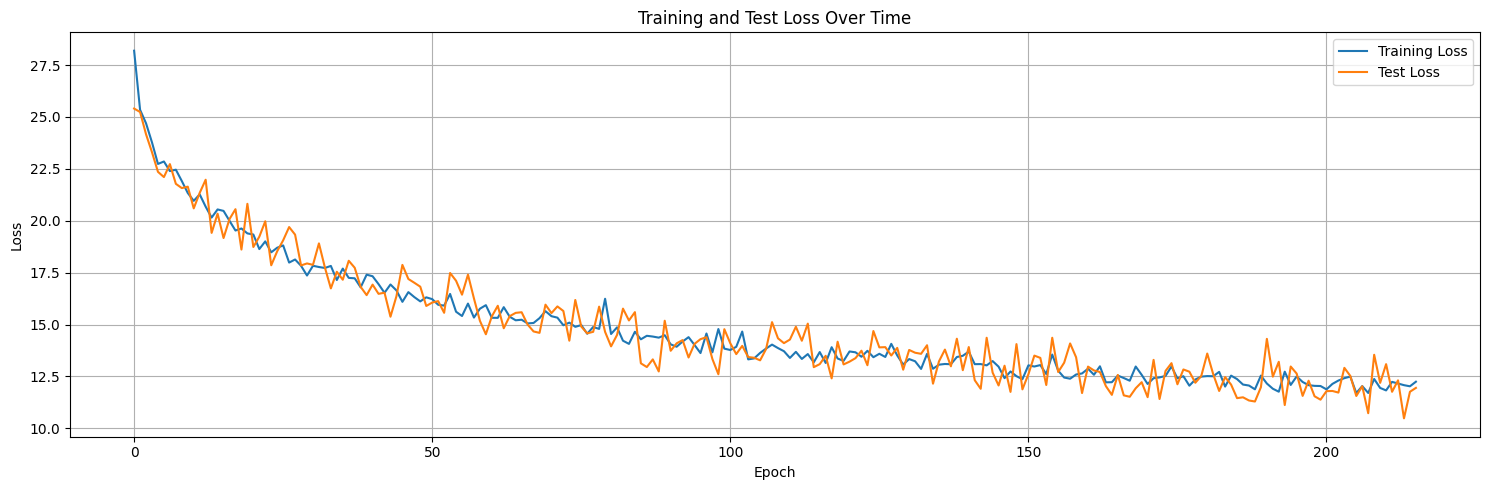

In [3]:
# 初始化列表用于收集训练和测试损失
train_loss = []  
test_loss = []  

with open('training_chengdu_epoch144_log.txt', 'r') as f:
    log_content = f.readlines()
# 正则表达式用于捕获epoch、迭代次数和损失值
train_epoch_regex = re.compile(r'Epoch: \[(\d+)\].*\[\s*(\d+)/\s*(\d+)\].*loss: ([\d.]+) \(')  
test_loss_regex = re.compile(r'Averaged stats:.*loss: ([\d.]+)')   
    
# 用字典存储每个epoch的损失
epoch_losses = {}

for line in log_content:  
    # 匹配并提取训练损失
    train_match = train_epoch_regex.search(line)  
    if train_match:  
        epoch, batch, total_batches, loss = train_match.groups()
        epoch = int(epoch)
        if epoch not in epoch_losses:
            epoch_losses[epoch] = []
        epoch_losses[epoch].append(float(loss))

    # 匹配并提取平均测试损失
    test_match = test_loss_regex.search(line)  
    if test_match:  
        test_loss.append(float(test_match.group(1)))  

# 计算每个epoch的平均损失
epochs = sorted(epoch_losses.keys())
train_losses = [np.mean(epoch_losses[e]) for e in epochs]
test_losses = test_loss  # 测试损失已经是每个epoch的平均值

# 创建图形
plt.figure(figsize=(15, 5))

# 在同一坐标轴上绘制两种损失
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

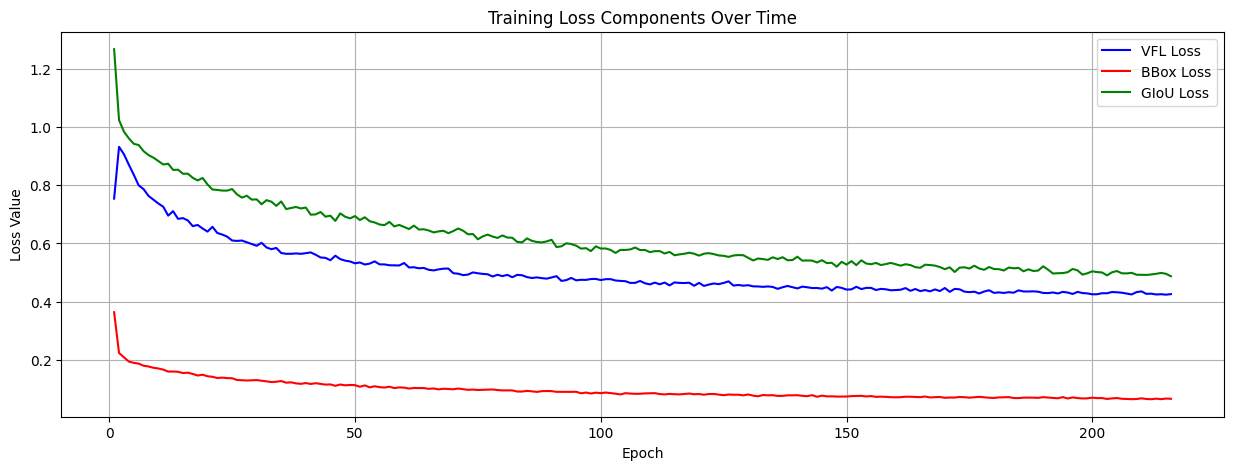

In [4]:
# 提取各个损失组件
vfl_pattern = r"Averaged stats:.*?loss_vfl: \d+\.\d+ \((\d+\.\d+)\)"
bbox_pattern = r"Averaged stats:.*?loss_bbox: \d+\.\d+ \((\d+\.\d+)\)"
giou_pattern = r"Averaged stats:.*?loss_giou: \d+\.\d+ \((\d+\.\d+)\)"

# 使用正则表达式匹配损失值
vfl_matches = re.findall(vfl_pattern, log_text, re.MULTILINE)
bbox_matches = re.findall(bbox_pattern, log_text, re.MULTILINE)
giou_matches = re.findall(giou_pattern, log_text, re.MULTILINE)

# 将匹配到的字符串转换为浮点数列表
vfl_losses = [float(x) for x in vfl_matches]
bbox_losses = [float(x) for x in bbox_matches]
giou_losses = [float(x) for x in giou_matches]

# 创建epoch序号列表
epochs = list(range(1, len(vfl_losses) + 1))

# 创建图形
plt.figure(figsize=(15, 5))

# 绘制三种损失曲线
plt.plot(epochs, vfl_losses, 'b-', label='VFL Loss')
plt.plot(epochs, bbox_losses, 'r-', label='BBox Loss') 
plt.plot(epochs, giou_losses, 'g-', label='GIoU Loss')

plt.title('Changes in Loss Components During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.grid(True)
plt.legend()
plt.show()


## 运行速度

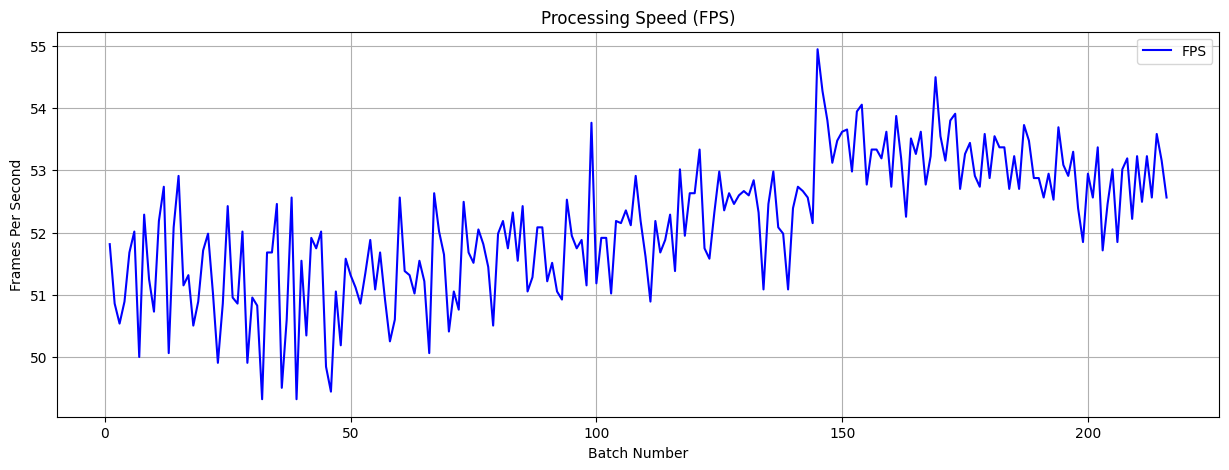

In [9]:
# 提取批处理时间信息
time_pattern = r"Test: Total time: \d+:\d+:\d+ \((\d+\.\d+) s / it\)"
time_matches = re.findall(time_pattern, log_text, re.MULTILINE)
batch_times = [float(x) for x in time_matches]

# 计算FPS (每秒帧数)
# 由于验证批次为8,需要将每个批次时间除以8来得到每张图片的处理时间
fps = [8/t for t in batch_times]  # FPS = batch_size / seconds_per_batch

# 创建批次序号列表
batches = list(range(1, len(batch_times) + 1))

# 创建图形
plt.figure(figsize=(15, 5))

# 绘制FPS曲线
plt.plot(batches, fps, 'b-', label='FPS')

plt.title('Processing Speed (FPS)')
plt.xlabel('Batch Number')
plt.ylabel('Frames Per Second')
plt.grid(True)
plt.legend()
plt.show()


## 评估指标

('209', '0.5524348044928746')


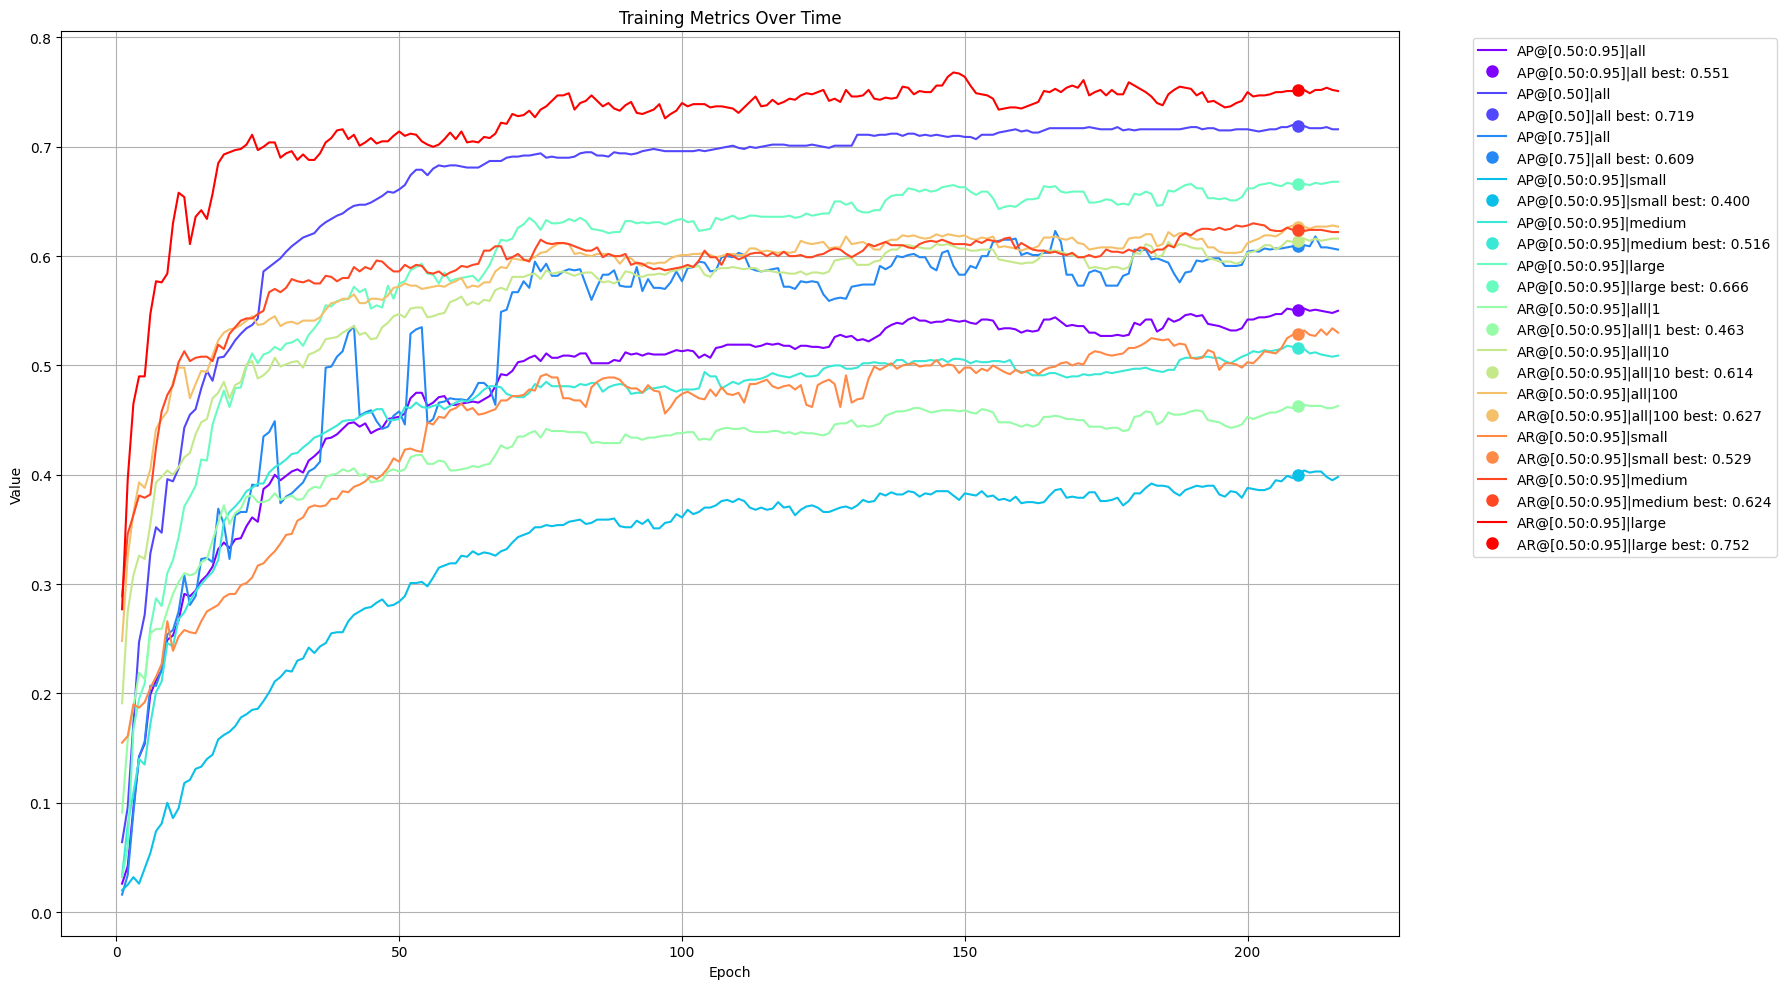

In [6]:
# 使用正则表达式提取不同的AP和AR值
metrics = {
    'AP@[0.50:0.95]|all': r"Average Precision  \(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)",
    'AP@[0.50]|all': r"Average Precision  \(AP\) @\[ IoU=0\.50      \| area=   all \| maxDets=100 \] = (\d+\.\d+)", 
    'AP@[0.75]|all': r"Average Precision  \(AP\) @\[ IoU=0\.75      \| area=   all \| maxDets=100 \] = (\d+\.\d+)",
    'AP@[0.50:0.95]|small': r"Average Precision  \(AP\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)",
    'AP@[0.50:0.95]|medium': r"Average Precision  \(AP\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)",
    'AP@[0.50:0.95]|large': r"Average Precision  \(AP\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)",
    'AR@[0.50:0.95]|all|1': r"Average Recall     \(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)",
    'AR@[0.50:0.95]|all|10': r"Average Recall     \(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)",
    'AR@[0.50:0.95]|all|100': r"Average Recall     \(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)",
    'AR@[0.50:0.95]|small': r"Average Recall     \(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)",
    'AR@[0.50:0.95]|medium': r"Average Recall     \(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)",
    'AR@[0.50:0.95]|large': r"Average Recall     \(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)"
}

# 存储结果到列表中
metric_values = {}
metric_epochs = {}

# 提取每个指标的值
for metric_name, pattern in metrics.items():
    matches = re.findall(pattern, log_text, re.MULTILINE)
    values = [float(x) for x in matches]
    epochs = list(range(1, len(values) + 1))
    metric_values[metric_name] = values
    metric_epochs[metric_name] = epochs

# 提取最佳epoch的信息
best_epoch_pattern = r"最佳状态:\s*{'epoch':\s*(\d+),\s*'coco_eval_bbox':\s*([\d\.]+)}"
best_epoch_match = re.findall(best_epoch_pattern, log_text)[-1]  # 获取最后一个匹配
best_epoch = int(best_epoch_match[0])
best_coco_eval = float(best_epoch_match[1])
best_metrics = {}
print(best_epoch_match)

# 提取最佳epoch的指标
for metric_name, values in metric_values.items():
    if len(values) >= best_epoch:
        best_metrics[metric_name] = values[best_epoch-1]
        
# 创建图表
plt.figure(figsize=(18, 10))

# 绘制所有指标
colors = plt.cm.rainbow(np.linspace(0, 1, len(metrics)))
for (metric_name, _), color in zip(metrics.items(), colors):
    # 绘制指标曲线
    plt.plot(metric_epochs[metric_name], metric_values[metric_name], '-', 
             label=metric_name, color=color)
    
    # 添加最佳epoch的标记点
    if len(metric_values[metric_name]) >= best_epoch:
        best_value = metric_values[metric_name][best_epoch-1]
        plt.plot(best_epoch, best_value, 'o', color=color, markersize=8,
                label=f'{metric_name} best: {best_value:.3f}')
plt.title('Training Metrics Over Time')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


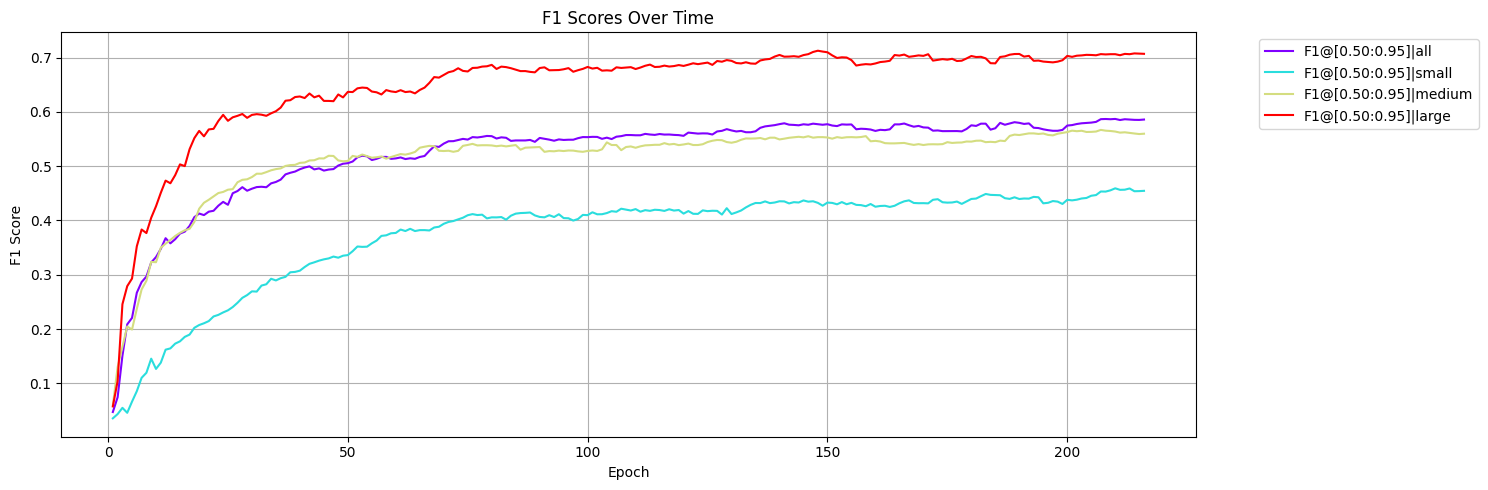

In [ ]:
# 为不同IoU阈值和区域计算F1分数
f1_metrics = {
    'F1@[0.50:0.95]|all': ('AP@[0.50:0.95]|all', 'AR@[0.50:0.95]|all|100'),
    'F1@[0.50:0.95]|small': ('AP@[0.50:0.95]|small', 'AR@[0.50:0.95]|small'),
    'F1@[0.50:0.95]|medium': ('AP@[0.50:0.95]|medium', 'AR@[0.50:0.95]|medium'), 
    'F1@[0.50:0.95]|large': ('AP@[0.50:0.95]|large', 'AR@[0.50:0.95]|large')
}

f1_values = {}
f1_epochs = {}

# 为每对指标计算F1分数
for f1_name, (ap_metric, ar_metric) in f1_metrics.items():
    ap_values = np.array(metric_values[ap_metric])
    ar_values = np.array(metric_values[ar_metric])
    
    # F1 = 2 * (精确率 * 召回率) / (精确率 + 召回率)
    f1 = 2 * (ap_values * ar_values) / (ap_values + ar_values)
    
    f1_values[f1_name] = f1
    f1_epochs[f1_name] = list(range(1, len(f1) + 1))

# 创建F1分数的图表
plt.figure(figsize=(15, 5))

colors = plt.cm.rainbow(np.linspace(0, 1, len(f1_metrics)))
for (metric_name, _), color in zip(f1_metrics.items(), colors):
    plt.plot(f1_epochs[metric_name], f1_values[metric_name], '-',
             label=metric_name, color=color)

plt.title('F1 Scores Over Time')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
